# MNIST oneNN Classifier

One-Nearest-Neighbor (oneNN) classifiers are among the most versatile classifiers in the field of machine learning. Their only prerequisite is a pairwise distance measure 

 			dist ( Xⁱₜₑₛₜ , Xʲₜᵣₐᵢₙ) 

assigning a notion of distance (or similarity) between two objects Xⁱₜₑₛₜ and  Xʲₜᵣₐᵢₙ. 1NN classifiers often provide reasonable classification accuracy and are easy to implement. The goal of classification is to correctly predict the class labels Yⁱₜₑₛₜ for all objects Xⁱₜₑₛₜ stemming from a test set of unlabeled objects by assigning the corresponding label Yʲₜᵣₐᵢₙ of the nearest instance  Xʲₜᵣₐᵢₙ from a labeled training set. The label assignment step for a fixed index i in the test set reads as follows:

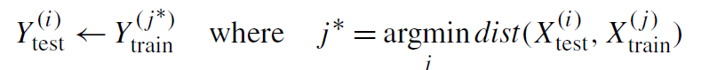

We will test 1NN classifier performance (i.e., accuracy) by using the MNIST dataset:

- X2.bin

    70,000 digit images
    

- Y2_int8.bin

    70,000 labels
    

For the 1NN classifier test, We will divide them into two sets:

1. 60,000 train set

2. 10,000 test set
    

In [1]:
using BenchmarkTools, Images, Colors, Plots, StatsBase

# Read digit images and their labels

In [ ]:
pwd()

In [2]:
cd("MNIST")

In [ ]:
readdir()

In [3]:
# requires 219,520,000 bytes to store 70,000 digit images
digits = Array{Float32, 2}(undef, 28*28, 70_000) 
read!("X2.bin", digits);

In [4]:
labels = Vector{Int8}(undef, 70_000) # requires 70,000 bytes
read!("Y2_int8.bin", labels);

# Pair-wise distance matrix computation functions 


The distance matrix is between train and test digit images.

In [5]:
# Define distance function of two float32 vector of size len
function distance(x, y, len)
    
    acc = zero(Float32)
    @simd for i in 1:len
        residue = x[i] - y[i]
        acc += residue * residue
    end
    
    return acc
end

distance (generic function with 1 method)

In [8]:
using LinearAlgebra

In [6]:
L = 10_000
x = fill(1f0, L)
y = fill(2f0, L);

In [13]:
@btime norm(x-y)

  4.450 μs (3 allocations: 39.12 KiB)


100.0f0

In [14]:
@btime sqrt(distance(x,y,L))

  702.479 ns (2 allocations: 32 bytes)


100.0f0

In [6]:
"""
    compute all_pair_distance matrix (n_train by n_test)
    distM(d, n_train, n_test, len)

    For MNIST dataset:
        d          digit images
        n_train    number of train images
        n_test     number of test images
                   (note: n_train + n_test ≤ 70,000)
        len        length (number of pixels) of each image (28*28)

"""
function distM(in_digits, n_train, n_test, len)
    
    distMat = Matrix{Float32}(undef, n_train, n_test)

    for i in 1:n_train
        for j in 1:n_test
            distMat[i, j] = distance(in_digits[:,i], in_digits[:,j + n_train], len)
        end
    end
    
    return distMat
end

distM

In [7]:
using Base.Threads

In [8]:
"""
    compute all_pair_distance matrix (n_train by n_test)
    distM_threads(d, n_train, n_test, len)

    For MNIST dataset:
        d          digit images
        n_train    number of train images
        n_test     number of test images
                   (note: n_train + n_test ≤ 70,000)
        len        length (number of pixels) of each image (28*28)

"""
function distM_threads(in_digits, n_train, n_test, len)
    
    distMat = Matrix{Float32}(undef, n_train, n_test)

    @threads for j in 1:n_test 
        for i in 1:n_train    
            @simd distMat[i, j] = distance(in_digits[:,i], in_digits[:,j + n_train], len)
        end
    end
    
    return distMat
end

distM_threads

# distM and distM_threads timing test

In [56]:
num_train = 6_000
num_test = 1_000
len = 28*28

784

In [57]:
@time d1 = distM(digits, num_train, num_test, len);

 12.187813 seconds (12.00 M allocations: 36.500 GiB, 13.25% gc time)


In [58]:
@time d2 = distM_threads(digits, num_train, num_test, len);

  8.994021 seconds (12.00 M allocations: 36.500 GiB, 39.27% gc time)


In [59]:
d1 == d2

false

# oneNN Classifier implementation

In [9]:
"""

  oneNN_accuracy(ntrain, ntest, distM, in_labels)   
 
        ntrain    number of train images
        ntest     number of test images
        distM     ntrain by ntest distance matrix
        in_labels lablels digit images

"""
function oneNN_accuracy(ntrain, ntest, distMat, in_labels)

    mis_match = Vector{Tuple{Int64, Int64}}([])
    match = 0
   
    for j in 1:ntest
        
        min_ind = 1
        m = distMat[1,j]
        for i in 2:ntrain
            x = distMat[i,j]
            if x < m
                m = x
                min_ind = i
            end
        end
    
        # test if match
        if in_labels[j + ntrain] == in_labels[min_ind] 
            match += 1
        else    # add to the mis_match list
            push!(mis_match, (j + ntrain, min_ind))
        end
    end
    
    println((match*100f0 / ntest), "% Accuracy")
    
    return mis_match
end

oneNN_accuracy

# oneNN classifier test 1 (6,000, 1,000)

In [10]:
n_train = 6_000
n_test = 1_000
len = 28*28;

In [11]:
@time dist = distM_threads(digits, n_train, n_test, len);

 10.394836 seconds (12.08 M allocations: 36.505 GiB, 42.77% gc time, 4.65% compilation time)


In [12]:
typeof(dist), size(dist)

(Matrix{Float32}, (6000, 1000))

In [13]:
mis_match = oneNN_accuracy(n_train, n_test, dist, labels);

92.8% Accuracy


In [14]:
length(mis_match)

72

# oneNN classifier test 2 (8,000, 1,000)

In [41]:
n_train = 8_000
n_test = 1_000
len = 28*28;

In [42]:
@time dist = distM_threads(digits, n_train, n_test, len);

 11.303857 seconds (16.00 M allocations: 48.667 GiB, 38.90% gc time)


In [43]:
typeof(dist), size(dist)

(Matrix{Float32}, (8000, 1000))

In [44]:
@time mis_match = oneNN_accuracy(n_train, n_test, dist, labels);

93.2% Accuracy
  0.008667 seconds (273 allocations: 9.352 KiB)


In [45]:
length(mis_match)

68

# oneNN classifier test 3 (10,000, 1,000)

In [46]:
n_train = 10_000
n_test = 1_000
len = 28*28;

In [47]:
@time dist = distM_threads(digits, n_train, n_test, len);

 13.728214 seconds (20.00 M allocations: 60.834 GiB, 37.12% gc time)


In [48]:
typeof(dist), size(dist)

(Matrix{Float32}, (10000, 1000))

In [49]:
@time mis_match = oneNN_accuracy(n_train, n_test, dist, labels);

95.7% Accuracy
  0.010994 seconds (183 allocations: 7.555 KiB)


In [50]:
length(mis_match)

43

# oneNN classifier test 4 (12,000, 1,000)

In [51]:
n_train = 12_000
n_test = 1_000
len = 28*28;

In [52]:
@time dist = distM_threads(digits, n_train, n_test, len);

 16.647904 seconds (24.00 M allocations: 73.001 GiB, 36.63% gc time)


In [53]:
typeof(dist), size(dist)

(Matrix{Float32}, (12000, 1000))

In [54]:
@time mis_match = oneNN_accuracy(n_train, n_test, dist, labels);

94.7% Accuracy
  0.012922 seconds (224 allocations: 8.352 KiB)


In [55]:
length(mis_match)

53

# oneNN classifier test 5 (15,000, 1,000)

In [57]:
n_train = 15_000
n_test = 1_000
len = 28*28;

In [58]:
@time dist = distM_threads(digits, n_train, n_test, len);

 21.492135 seconds (30.00 M allocations: 91.251 GiB, 36.84% gc time)


In [59]:
typeof(dist), size(dist)

(Matrix{Float32}, (15000, 1000))

In [60]:
@time mis_match = oneNN_accuracy(n_train, n_test, dist, labels);

95.1% Accuracy
  0.016067 seconds (202 allocations: 7.852 KiB)


In [61]:
length(mis_match)

49

# oneNN classifier test 5 (20,000, 1,000)

In [45]:
n_train = 20_000
n_test = 1_000
len = 28*28;

In [46]:
@time dist = distM_threads(digits, n_train, n_test, len);

 28.576281 seconds (40.00 M allocations: 121.668 GiB, 37.41% gc time)


In [47]:
typeof(dist), size(dist)

(Matrix{Float32}, (20000, 1000))

In [48]:
@time mis_match = oneNN_accuracy(n_train, n_test, dist, labels);

96.7% Accuracy
  0.021216 seconds (36 allocations: 1.805 KiB)


In [49]:
length(mis_match)

33

# Plot mis_match pair Images

In [50]:
length(mis_match)

33

In [51]:
mis_match[1], labels[mis_match[1][1]], labels[mis_match[1][2]]

((20017, 589), 3, 2)

In [52]:
test = reshape(digits[:,mis_match[1][1]], 28, 28);

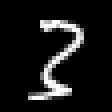

In [53]:
test = (Matrix{Gray{N0f8}}(test))'

In [54]:
train = reshape(digits[:,mis_match[1][2]], 28, 28);

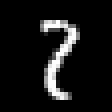

In [55]:
train = (Matrix{Gray{N0f8}}(train))'

In [31]:
mis_match[2], labels[mis_match[2][1]], labels[mis_match[2][2]]

((6067, 1785), 8, 6)

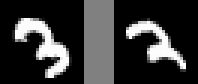

In [59]:
nm = 5
test = reshape(digits[:,mis_match[nm][1]], 28, 28);
test = (Matrix{Gray{N0f8}}(test))';
train = reshape(digits[:,mis_match[nm][2]], 28, 28);
train = (Matrix{Gray{N0f8}}(train))';
mosaicview(test, train; fillvalue=0.5, npad=10, ncol=2, rowmajor=true)

# Mis-Match Digist Distribution

In [35]:
using Plots

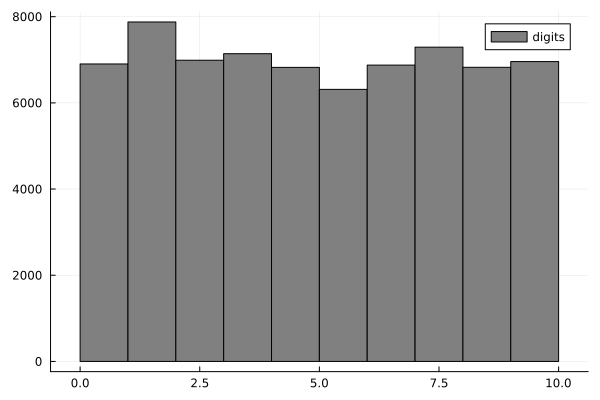

In [40]:
histogram(labels, label="digits", bins=11, color=:gray)

In [60]:
mis_match_digits = [labels[t[1]] for t in mis_match ];

In [61]:
typeof(mis_match_digits), length(mis_match_digits)

(Vector{Int8}, 33)

In [62]:
for i in 1:10
    x = filter(==(i-1), mis_match_digits)
    println(" digit $(i-1): ", length(x))
end

 digit 0: 0
 digit 1: 2
 digit 2: 0
 digit 3: 3
 digit 4: 2
 digit 5: 5
 digit 6: 2
 digit 7: 4
 digit 8: 8
 digit 9: 7


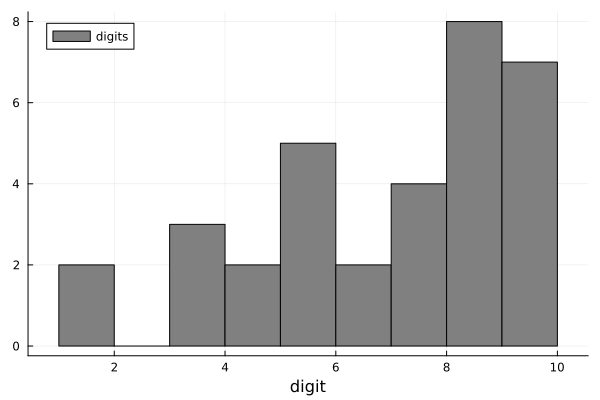

In [63]:
histogram(mis_match_digits, label="digits", bins=11, color=:gray)
xlabel!("digit")

# Mis_match of Digit 8 analysis

In [64]:
mis_match_8 = [labels[t[2]] for t in mis_match if labels[t[1]] == 8]

8-element Vector{Int8}:
 6
 3
 7
 5
 3
 5
 3
 3

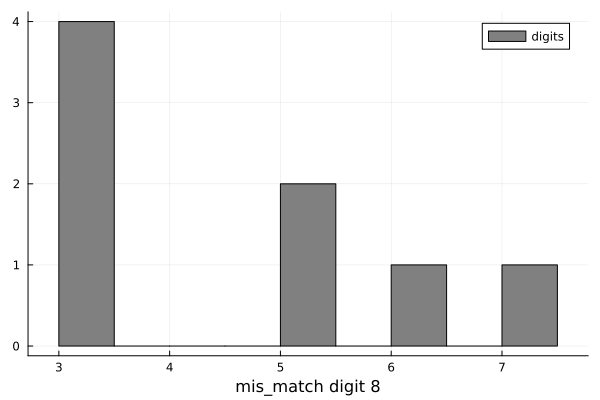

In [65]:
histogram(mis_match_8, label="digits", bins=11, color=:gray)
xlabel!("mis_match digit 8")

# For 60,000 by10,000 distM_threads computing time

In [ ]:
# Matrix(60000,10000) needs about 2GB of memory space
n_train = 60_000
n_test = 10_000
len = 28*28

In [39]:
# This takes about 659 seconds
@time dist = distM_threads(digits, n_train, n_test, len);

659.253094 seconds (1.20 G allocations: 3.564 TiB, 32.46% gc time, 0.06% compilation time)
